# Measuring Word Similarity with BERT (English Language Public Domain Poems)

By [The BERT for Humanists](https://melaniewalsh.github.io/BERT-for-Humanists/) Team

How can we measure the similarity of words in a collection of texts? For example, how similar are the words "nature" and "science" in a collection of 16th-20th century English language poems? Do 20th-century poets use the word "science" differently than 16th-century poets? Can we map all the different uses and meanings of the word "nature"?

The short answer is: yes! We can explore all of these questions with BERT, a natural language processing model that has revolutionized the field.

BERT turns words or tokens into vectors — essentially, a list of numbers in a coordinate system (x, y). We can then use the geometric similarity between these resulting vectors as a way to represent varying types of similarity between words.

## In This Notebook
In this Colab notebook, we will specifically analyze a collection of poems scraped from [Public-Domain-Poetry.com](http://public-domain-poetry.com/) with the [DistilBert model](https://huggingface.co/transformers/model_doc/distilbert.html) and the HuggingFace Python library. DistilBert is a smaller — yet still powerful! — version of BERT. By using the rich representations of words that BERT produces, we will then explore the multivalent meanings of particular words in context and over time.

We hope this notebook will help illustrate how BERT works, how well it works, and how you might use BERT to explore the similarity of words in a collection of texts. It is surprising, for example, that BERT works as well as it does, without any fine-tuning, on poems that were published hundreds of years before the text data it was trained on (Wikiepdia pages and self-published novels). 

But we also hope that these results will expose some of the limitations and challenges of BERT. We have to disregard poetic line breaks, for example, and we see that BERT has trouble with antiquated words like "thine," which don't show up in its contemporary vocabulary.

In [ ]:
#@title BERT Word Vectors: A Preview { display-mode: "form" }
#@title: Hover
import pandas as pd
import altair as alt

url = "https://raw.githubusercontent.com/melaniewalsh/BERT-4-Humanists/main/data/bert-word-nature.csv"
df = pd.read_csv(url, encoding='utf-8')

search_keywords = ['nature', 'science', 'religion', 'art']
color_by = 'word'

alt.Chart(df, title=f"Word Similarity: {', '.join(search_keywords).title()}").mark_circle(size=200).encode(
    alt.X('x',
        scale=alt.Scale(zero=False)
    ), y="y",
    color= color_by,
    href="link",
    tooltip=['title', 'word', 'poem_title', 'author', 'period']
    ).interactive().properties(
    width=500,
    height=500
)

alt.Chart(...)

The plot above displays a preview of our later results. This is what we're working toward!

You can hover over each point to see the instance of each word in context. If you press `Shift` and click on a point, you will be taken to the original poem on Public-Domain-Poetry.com. Try it out!

## **Import necessary Python libraries and modules**

Ok enough introduction! Let's get started.

To use the HuggingFace [`transformers` Python library](https://huggingface.co/transformers/installation.html), we first need to install it with `pip`.

In [ ]:
!pip install transformers

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


Then we will import the DistilBertModel and DistilBertTokenizerFast from the Hugging Face `transformers` library. We will also import a handful of other Python libraries and modules.

In [ ]:
# For BERT
from transformers import DistilBertTokenizerFast, DistilBertModel

# For data manipulation and analysis
import pandas as pd
pd.options.display.max_colwidth = 200
import numpy as np
from sklearn.decomposition import PCA

# For interactive data visualization
import altair as alt

## **Load text dataset**

Our dataset contains around ~30 thousand poems scraped from  http://public-domain-poetry.com/. This website hosts a curated collection of poems that have fallen out of copyright, which makes them easier for us to share on the web. 
You can find the data in our [GitHub repository](https://github.com/melaniewalsh/BERT-4-Humanists/blob/main/data/public-domain-poetry.csv).

We don't have granular date information about when each poem was published, but we do know the birth dates of most of our authors, which we've used to loosely categorize the poems by time period. The poems in our data range from the Middle Ages to the 20th Century, but most come from the 19th Century. The data features both well-known authors — William Wordsworth, Emily Elizabeth Dickinson, Paul Laurence Dunbar, Walt Whitman, Shakespeare — as well as less well-known authors.

Below we will use the Python library `pandas` to read in our CSV file of poems. It is convenient (especially for Colab notebooks) that `pandas` allows you to read in files directly from the web.

To be clear, however, knowledge of `pandas` is not necessary to use BERT. This is simply how we've chosen to load our data. All you really need  is a list of texts (poems, passages, etc.). You can create this list however you are most comfortable.

In [ ]:
url = "https://raw.githubusercontent.com/melaniewalsh/BERT-4-Humanists/main/data/public-domain-poetry.csv"

poetry_df = pd.read_csv(url, encoding='utf-8')
# Show 5 random rows
poetry_df.sample(5)

,author,title,text,lifespan,birth_year,death_year,link,period
8086,Freeman Edwin Miller,The Willow,"A song for the willow, the wild weeping willow,\r\nThat murmurs a dirge to the rapturous days,\r\nAnd moans when the kiss of the breeze laden billow\r\nEntangles and dangles among the sad sprays!\...",1864 - 1951,1864.0,1951.0,http://public-domain-poetry.com/freeman-edwin-miller/willow-26405,19th Century
27433,Walter De La Mare,Tired Tim,"Poor Tired Tim! It's sad for him.\r\nHe lags the long bright morning through,\r\nEver so tired of nothing to do;\r\nHe moons and mopes the livelong day,\r\nNothing to think about, nothing to say;\...",25 April 1873-22 June 1956,1873.0,1956.0,http://public-domain-poetry.com/walter-de-la-mare/tired-tim-33377,20th Century
7391,Francesco Petrarca (Petrarch),To Laura In Death. Sonnet LXXXV,"Tennemi Amor anni ventuno ardendo.\n\r\nHE CONFESSES AND REGRETS HIS SINS, AND PRAYS GOD TO SAVE HIM FROM ETERNAL DEATH.\n\n\r\nLove held me one and twenty years enchain'd,\r\nHis flame was joy--f...","July 20, 1304-July 19, 1374",1304.0,1374.0,http://public-domain-poetry.com/francesco-petrarca/to-laura-in-death-sonnet-lxxxv-28753,12th-15th Centuries (Middle English)
20763,Robert Herrick,"The Present; Or, The Bag Of The Bees","Fly to my mistress, pretty pilfering bee,\r\nAnd say thou bring'st this honey-bag from me;\r\nWhen on her lip thou hast thy sweet dew placed,\r\nMark if her tongue but slyly steal a taste;\r\nIf s...","Baptized - August 24, 1591- October 1674",1591.0,1674.0,http://public-domain-poetry.com/robert-herrick/present-or-the-bag-of-the-bees-2316,16th-17th Centuries (Early Modern)
1788,Alice Christiana Gertrude Thompson Meynell,Sonnet - The Neophyte,"Who knows what days I answer for to-day:\r\nGiving the bud I give the flower. I bow\r\nThis yet unfaded and a faded brow;\r\nBending these knees and feeble knees, I pray.\n\r\nThoughts yet unripe ...",22 September 1847 - 27 November 1922,1847.0,1922.0,http://public-domain-poetry.com/alice-meynell/sonnet-the-neophyte-38445,19th Century


In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
import pandas as pd
import numpy as np

df_taming = pd.read_csv('/content/drive/MyDrive/Colab Notebooks/honors thesis/punctuation/taming/df_tamingoftheshrew_sentence_withactbreakdown.csv')
df_tamertamed = pd.read_csv('/content/drive/MyDrive/Colab Notebooks/honors thesis/punctuation/df_tamertamedwithpunctuation.csv')

In [ ]:
for index, row in df_taming.iterrows():
  df_taming['title'] = 'The Taming of the Shrew'
 
for index, row in df_tamertamed.iterrows():
 df_tamertamed['title'] = 'Tamer Tamed'

In [ ]:
#@title *Click here to see how you might load a dataset from your own computer*
#from google.colab import files
#uploaded = files.upload()

Let's check to see how many poems are in this dataset:

In [ ]:
len(poetry_df)

31080

Let's check to see which authors show up the most in this dataset to get a sense of its contours:

In [ ]:
poetry_df['author'].value_counts()[:20]

Robert Herrick                   1464
Madison Julius Cawein            1345
William Wordsworth                963
Thomas Moore                      853
Thomas Hardy                      655
Rudyard Kipling                   638
Robert Burns                      499
John Greenleaf Whittier           481
Algernon Charles Swinburne        461
Emily Elizabeth Dickinson         447
Paul Laurence Dunbar              417
John Clare                        382
William Butler Yeats              378
Francesco Petrarca (Petrarch)     375
Paul Cameron Brown                341
Walt Whitman                      338
Edgar Lee Masters                 331
Percy Bysshe Shelley              330
Walter De La Mare                 329
Oliver Wendell Holmes             329
Name: author, dtype: int64

In [ ]:
df = pd.concat([df_taming,df_tamertamed])

In [ ]:
df['sentence']

0                                                                                                                                          Enter Beggar ( Christopher Sly ) and Hostess 
1                                                                                                                                                             I’ll feeze you , in faith 
2                                                                                                                                                          A pair of stocks , you rogue 
3                                                                                                                                                                      You’re a baggage 
4                                                                                                                                                                The Slys are no rogues 
                                                                           

Let's check to see what time periods show up the most in this dataset to get a sense of its contours:

<AxesSubplot:>

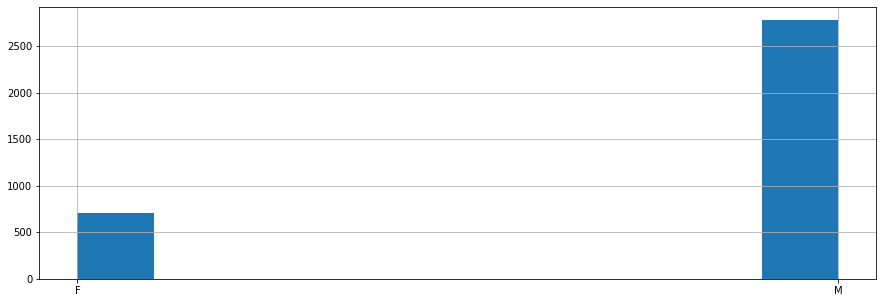

In [ ]:
# Sort values, then create a histogram, and define the size of the figure
df['speaker_gender'].sort_values().hist(figsize=(15, 5))

## **Sample text dataset**

Though we wish we could analyze all the poems in this data, Colab tends to crash if we try to use more than 4-5,000 poems —  even with DistilBert, the smaller version of BERT. This is an important limitation to keep in mind. If you'd like to use more text data, you might consider upgrading to a paid version of Colab (with more memory or GPUs) or using a compute cluster.

To reduce the number of poems, we will take a random sample of 1,000 poems from four different time periods: the 20th Century, 19th Century, 18th Century, and the Early Modern period.

In [ ]:
# Filter the DataFrame for only a given time period, then randomly sample 1000 rows
nineteenth_sample = poetry_df[poetry_df['period'] == '19th Century'].sample(1000)
twentieth_sample = poetry_df[poetry_df['period'] == '20th Century'].sample(1000)
eighteenth_sample = poetry_df[poetry_df['period'] == '18th Century'].sample(1000)
sixteenth_sample = poetry_df[poetry_df['period'] == '16th-17th Centuries (Early Modern)'].sample(1000)

In [ ]:
# Merge these random samples into a new DataFrame
poetry_df = pd.concat([sixteenth_sample, eighteenth_sample, twentieth_sample, nineteenth_sample])

In [ ]:
df = pd.concat([df_taming,df_tamertamed])

In [ ]:
poetry_df['period'].value_counts()

16th-17th Centuries (Early Modern)    1000
18th Century                          1000
20th Century                          1000
19th Century                          1000
Name: period, dtype: int64

Finally, let's make a list of poems from our Pandas DataFrame.

In [ ]:
drama_texts_tamer = df_tamertamed['sentence'].tolist()
drama_texts_taming = df_taming['sentence'].tolist()

Let's examine a poem in our dataset:

In [ ]:
len(drama_texts_tamer)

1726

In [ ]:
len(drama_texts_taming)

2349

In [ ]:
#print(drama_texts[0])

## **Encode/tokenize text data for BERT**

Next we need to transform our poems into a format that BERT (via Huggingface) will understand. This is called *encoding* or *tokenizing* the data.

We will tokenize the poems with the `tokenizer()` from HuggingFace's `DistilBertTokenizerFast`. Here's what the `tokenizer()` will do:

1. Truncate the texts if they're more than 512 tokens or pad them if they're fewer than 512 tokens. If a word is not in BERT's vocabulary, it will be broken up into smaller "word pieces," demarcated by a `##`.

2. Add in special tokens to help BERT:
    - [CLS] — Start token of every document
    - [SEP] — Separator between each sentence 
    - [PAD] — Padding at the end of the document as many times as necessary, up to 512 tokens
    - &#35;&#35; — Start of a "word piece" 

Here we will load `DistilBertTokenizerFast` from HuggingFace library, which will help us transform and encode the texts so they can be used with BERT.

In [ ]:
from transformers import DistilBertTokenizerFast

In [ ]:
tokenizer = DistilBertTokenizerFast.from_pretrained('distilbert-base-uncased')

The `tokenizer()` will break word tokens into word pieces, truncate to 512 tokens, and add padding and special BERT tokens.

In [ ]:
tokenized_poems_tamer = tokenizer(drama_texts_tamer, truncation=True, padding=True, return_tensors="pt")
tokenized_poems_taming = tokenizer(drama_texts_taming, truncation=True, padding=True, return_tensors="pt")

Let's examine the first tokenized poem. We can see that the special BERT tokens have been inserted where necessary.

In [ ]:
' '.join(tokenized_poems_tamer[0].tokens)
' '.join(tokenized_poems_taming[0].tokens)

'[CLS] enter beg ##gar ( christopher sly ) and hostess [SEP] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PA

<br><br>

## **Load pre-trained BERT model**

Here we will load a pre-trained BERT model. To speed things up we will use a GPU, but using GPU involves a few extra steps.
The command `.to("cuda")` moves data from regular memory to the GPU's memory.




In [ ]:
from transformers import DistilBertModel

In [ ]:
model = DistilBertModel.from_pretrained('distilbert-base-uncased').to("cuda")

Some weights of the model checkpoint at distilbert-base-uncased were not used when initializing DistilBertModel: ['vocab_projector.weight', 'vocab_transform.bias', 'vocab_transform.weight', 'vocab_layer_norm.bias', 'vocab_layer_norm.weight', 'vocab_projector.bias']
- This IS expected if you are initializing DistilBertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing DistilBertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


## **Get BERT word embeddings for each document in a collection**

To get word embeddings for all the words in our collection, we will use a `for` loop.

For each poem in our list `poetry_texts`, we will tokenize the poem, and we will extract the vocabulary word ID for each word/token in the poem (to use for later reference). Then we will run the tokenized poem through the BERT model and extract the vectors for each word/token in the poem.

We thus create two big lists for all the poems in our collection — `doc_word_ids` and `doc_word_vectors`.

In [ ]:
###
#TAMER NOW

# List of vocabulary word IDs for all the words in each document (aka each poem)
doc_word_ids = []
# List of word vectors for all the words in each document (aka each poem)
doc_word_vectors = []

# Below we will slice our poem to ignore the first (0th) and last (-1) special BERT tokens
start_of_words = 1
end_of_words = -1

# Below we will index the 0th or first document, which will be the only document, since we're analzying one poem at a time
first_document = 0

for i, poem in enumerate(drama_texts_tamer):
  
    # Here we tokenize each poem with the DistilBERT Tokenizer
    inputs = tokenizer(poem, return_tensors="pt", truncation=True, padding=True)

    # Here we extract the vocabulary word ids for all the words in the poem (the first or 0th document, since we only have one document)
    # We ignore the first and last special BERT tokens
    # We also convert from a Pytorch tensor to a numpy array
    doc_word_ids.append(inputs.input_ids[first_document].numpy()[start_of_words:end_of_words])

    # Here we send the tokenized poems to the GPU
    # The model is already on the GPU, but this poem isn't, so we send it to the GPU
    inputs.to("cuda")
    # Here we run the tokenized poem through the DistilBERT model
    outputs = model(**inputs)

    # We take every element from the first or 0th document, from the 2nd to the 2nd to last position
    # Grabbing the last layer is one way of getting token vectors. There are different ways to get vectors with different pros and cons
    doc_word_vectors.append(outputs.last_hidden_state[first_document,start_of_words:end_of_words,:].detach().cpu().numpy())


Confirm that we have the same number of documents for both the tokens and the vectors:

In [ ]:
len(doc_word_ids), len(doc_word_vectors)

(1726, 1726)

In [ ]:
doc_word_ids[0], doc_word_vectors[0]

(array([ 4607, 22822, 19137,  1010,  2061,  8458, 10085,  4244,  1010,
         1998, 25283,  3695,  1010,  2007, 18040,  1010,  2004,  2013,
         1037,  5030]),
 array([[-0.05305526,  0.37905672,  0.07833516, ..., -0.17374241,
          0.21062511, -0.13870583],
        [ 0.1262493 ,  0.17946516,  0.42648718, ..., -0.14216661,
          0.42691347,  0.7582903 ],
        [-0.27405804, -0.04980982,  0.00445879, ..., -0.15404958,
          0.27221003,  0.8036827 ],
        ...,
        [-0.26510304, -0.55182207,  0.49340782, ..., -0.22109556,
         -0.08579449,  0.04642269],
        [-0.2302802 , -0.4401955 ,  0.57462156, ..., -0.24288498,
         -0.12710504,  0.392782  ],
        [ 0.38195187, -0.3310294 ,  0.40977085, ..., -0.25561902,
          0.11130783, -0.47110865]], dtype=float32))

## **Concatenate all word IDs/vectors for all documents**

Each element of these lists contains all the tokens/vectors for one document. But we want to concatenate them into two giant collections.

In [ ]:
all_word_ids = np.concatenate(doc_word_ids)
all_word_vectors = np.concatenate(doc_word_vectors, axis=0)

We want to make comparisons between vectors quickly. One common option is *cosine similarity*, which measures the angle between vectors but ignores their length. We can speed this computation up by setting all the poem vectors to have length 1.0.

In [ ]:
# Calculating the length of each vector (Pythagorean theorem)
row_norms = np.sqrt(np.sum(all_word_vectors ** 2, axis=1))
# Dividing every vector by its length
all_word_vectors /= row_norms[:,np.newaxis]

## **Find all word positions in a collection**

We can use the array `all_word_ids` to find all the places, or *positions*, in the collection where a word appears.

We can find a word's vocab ID in BERT with `tokenizer.vocab` and then check to see where/how many times this ID occurs in `all_word_ids`.

In [ ]:
def get_word_positions(words):
  
  """This function accepts a list of words, rather than a single word"""

  # Get word/vocabulary ID from BERT for each word
  word_ids = [tokenizer.vocab[word] for word in words]

  # Find all the positions where the words occur in the collection
  word_positions = np.where(np.isin(all_word_ids, word_ids))[0]

  return word_positions

Here we'll check to see all the places where the word "bank" appears in the collection.

In [ ]:
get_word_positions(["love"])

array([  459,   861,   933,  1133,  1445,  1700,  1714,  5007,  5063,
        5068,  7279,  7302,  7725,  9843,  9862, 10013, 12630, 12910,
       13028, 13031, 13140, 13290, 13313, 13527, 13726, 13748, 13756,
       14543, 14574, 15675, 15924, 16219, 16542, 16681, 16711, 16870,
       17542, 17972, 18205, 18763, 19224, 20550, 20763, 21654, 22081,
       22861, 24388, 24539, 24710, 24774, 25317, 27032, 27406, 27440,
       28390, 29367])

In [ ]:
word_positions = get_word_positions(["love"])

## **Find word from word position**

Nice! Now we know all the positions where the word "bank" appears in the collection. But it would be more helpful to know the actual words that appear in context around it. To find these context words, we have to convert position IDs back into words.

In [ ]:
# Here we create an array so that we can go backwards from numeric token IDs to words
word_lookup = np.empty(tokenizer.vocab_size, dtype="O")

for word, index in tokenizer.vocab.items():
    word_lookup[index] = word

Now we can use `word_lookup` to find a word based on its position in the collection.

In [ ]:
word_positions = get_word_positions(["love"])

for word_position in word_positions:
  print(word_position, word_lookup[all_word_ids[word_position]])

459 love
861 love
933 love
1133 love
1445 love
1700 love
1714 love
5007 love
5063 love
5068 love
7279 love
7302 love
7725 love
9843 love
9862 love
10013 love
12630 love
12910 love
13028 love
13031 love
13140 love
13290 love
13313 love
13527 love
13726 love
13748 love
13756 love
14543 love
14574 love
15675 love
15924 love
16219 love
16542 love
16681 love
16711 love
16870 love
17542 love
17972 love
18205 love
18763 love
19224 love
20550 love
20763 love
21654 love
22081 love
22861 love
24388 love
24539 love
24710 love
24774 love
25317 love
27032 love
27406 love
27440 love
28390 love
29367 love


We can also look for the 3 words that come before "bank" and the 3 words that come after it.

In [ ]:
word_positions = get_word_positions(["love"])

for word_position in word_positions:

  # Slice 3 words before "bank"
  start_pos = word_position - 3
  # Slice 3 words after "bank"
  end_pos = word_position + 4

  context_words = word_lookup[all_word_ids[start_pos:end_pos]]
  # Join the words together
  context_words = ' '.join(context_words)
  print(word_position, context_words)

459 my word i love him : but
861 of words i love you , and
933 our heart ##y love such wrong ,
1133 money rowland oh love forgive me ,
1445 it for pure love to the matter
1700 me , and love example here is
1714 man ’ s love that loves the
5007 and let your love confirm it stay
5063 riddle : i love you , and
5068 , and i love you not it
7279 i do not love these favors :
7302 ’ s a love token for you
7725 of her earnest love , there grew
9843 , even for love sake — i
9862 , our old love and our friendship
10013 free and liberal love , a pardon
12630 can win her love , i ’
12910 ll no more love , that ’
13028 be brought to love , and love
13031 love , and love a woman ,
13140 to be in love and why for
13290 thou cans ##t love so near to
13313 those things in love , ne ’
13527 ne ’ er love again i think
13726 s all one love you as much
13748 let ’ em love : ten pound
13756 , i never love that woman there
14543 ; do you love her i would
14574 violence some women love to struggle she
15675 ,

Let's make some functions that will help us get the context words around a certain word position for whatever size window (certain number of words before and after) that we want.

The first function `get_context()` will simply return the tokens without cleaning them, and the second function `get_context_clean()` will return the tokens in a more readable fashion.

In [ ]:
def get_context(word_id, window_size=10):
  
  """Simply get the tokens that occur before and after word position"""

  start_pos = max(0, word_id - window_size) # The token where we will start the context view
  end_pos = min(word_id + window_size + 1, len(all_word_ids)) # The token where we will end the context view

  # Make a list called tokens and use word_lookup to get the words for given token IDs from starting position up to the keyword
  tokens = [word_lookup[word] for word in all_word_ids[start_pos:end_pos] ]
  
  context_words = " ".join(tokens)

  return context_words

In [ ]:
import re

def get_context_clean(word_id, window_size=10):
  
  """Get the tokens that occur before and after word position AND make them more readable"""

  keyword = word_lookup[all_word_ids[word_id]]
  start_pos = max(0, word_id - window_size) # The token where we will start the context view
  end_pos = min(word_id + window_size + 1, len(all_word_ids)) # The token where we will end the context view

  # Make a list called tokens and use word_lookup to get the words for given token IDs from starting position up to the keyword
  tokens = [word_lookup[word] for word in all_word_ids[start_pos:end_pos] ]
  
  # Make wordpieces slightly more readable
  # This is probably not the most efficient way to clean and correct for weird spacing
  context_words = " ".join(tokens)
  context_words = re.sub(r'\s+([##])', r'\1', context_words)
  context_words = re.sub(r'##', r'', context_words)
  context_words = re.sub('\s+\'s', '\'s', context_words)
  context_words = re.sub('\s+\'d', '\'d', context_words)
  context_words = re.sub('\s\'er', '\'er', context_words)
  context_words = re.sub(r'\s+([-,:?.!;])', r'\1', context_words)
  context_words = re.sub(r'([-\'"])\s+', r'\1', context_words)
  context_words = re.sub('\s+\'s', '\'s', context_words)
  context_words = re.sub('\s+\'d', '\'d', context_words)

  # Bold the keyword by putting asterisks around it
  if keyword in context_words:
    context_words = re.sub(f"\\b{keyword}\\b", f"**{keyword}**", context_words)
    context_words = re.sub(f"\\b({keyword}[esdtrlying]+)\\b", fr"**\1**", context_words)

  return context_words

To visualize the search keyword even more easily, we're going to import a couple of Python modules that will allow us to output text with bolded words and other styling. Here we will make a function `print_md()` that will allow us to print with Markdown styling.

In [ ]:
from IPython.display import Markdown, display

def print_md(string):
    display(Markdown(string))

In [ ]:
word_positions = get_word_positions(["love"])

for word_position in word_positions:

  print_md(f"<br> {word_position}:  {get_context_clean(word_position)} <br>")

<br> 459:  s a good fellow, and on my word i **love** him: but to think a fit match for this <br>

<br> 861:  if your affections be not made of words i **love** you, and you know how dearly rowland, <br>

<br> 933:  why should we do our honest and our hearty **love** such wrong, to overrun our fortunes then you flat <br>

<br> 1133:  high priest among the jews: his money rowland oh **love** forgive me, what faith hast thou why, <br>

<br> 1445:  hang itself, should i but cross it for pure **love** to the matter i must hatch it nay never look <br>

<br> 1700:  fears and modest blushes, view me, and **love** example here is your sister here is the brave old <br>

<br> 1714:  your sister here is the brave old man ’ s **love** that **loves** the young man ay and hold thee <br>

<br> 5007:  credit you maria, come down, and let your **love** confirm it stay there sir, that bargain ’ s <br>

<br> 5063:  stock a kingdom why this is a riddle: i **love** you, and i **love** you not it is so <br>

<br> 5068:  is a riddle: i **love** you, and i **love** you not it is so: and till your own <br>

<br> 7279:  ear and exit how ’ s this i do not **love** these favors: save you the devil take thee — <br>

<br> 7302:  him by th ’ nose oh there ’ s a **love** token for you: thank me now i ’ ll <br>

<br> 7725:  violent neither — it may be out of her earnest **love**, there grew a longing ( as you know women <br>

<br> 9843:  her i do beseech you, even for **love** sake — i will rowland she may sooner count the <br>

<br> 9862:  count the good i have thought her, our old **love** and our friendship, shed one true tear, mean <br>

<br> 10013:  that i grant her out of my free and liberal **love**, a pardon, which you and all men else <br>

<br> 12630:  repentance, and undoing can win her **love**, i ’ ll make a shift for one when <br>

<br> 12910:  counsel i shall hang first i ’ ll no more **love**, that ’ s certain, ’ tis a bane <br>

<br> 13028:  him of a man, and could be brought to **love**, and **love** a woman, ’ twould make <br>

<br> 13031:  man, and could be brought to **love**, and **love** a woman, ’ twould make his head ache <br>

<br> 13140:  wilt thou rowland as ’ tis to be in **love** and why for virtue sake and why for virtue ’ <br>

<br> 13290:  best a swabber, if thou canst **love** so near to keep thy making, yet thou wil <br>

<br> 13313:  thy language why o tranio, those things in **love**, ne ’ er talk as we do, no <br>

<br> 13527:  io wilt thou rowland, certain ne ’ er **love** again i think so, certain, and if i <br>

<br> 13726:  ’ th ’ wager that ’ s all one **love** you as much, or more, than she now <br>

<br> 13748:  you ’ tis a good hearing, let ’ em **love**: ten pound more, i never **love** that woman <br>

<br> 13756:  ’ em **love**: ten pound more, i never **love** that woman there it is; and so an hundred <br>

<br> 14543:  pray you tell me one thing truly; do you **love** her i would i did not, upon that condition <br>

<br> 14574:  , her modesty required a little violence some women **love** to struggle she had it, and so much that <br>

<br> 15675:  , nor obedience in way of duty, but of **love**, and credit; all i expect is but a <br>

<br> 15924:  pleasure now you perceive him sophocles i **love** thee above thy vanity, thou faithless creature would <br>

<br> 16219:  doting had i not wife enough to turn my **love** too did i want vexation, or any <br>

<br> 16542:  still; i would yet remember you give him his **love** wench; the young man has employment for ’ <br>

<br> 16681:  must do so sometimes, and oftentimes; **love** were too serious else a witty woman had you **loved** <br>

<br> 16711:  ; and i had **loved** you so: you may **love** worse sir, but that is not material i shall <br>

<br> 16870:  sorrow may induce me to forgive you, but never **love** again; if i stay longer, i have lost <br>

<br> 17542:  ll to the lodge; some that are kind and **love** me, i know will visit me petruchio <br>

<br> 17972:  your office and what he wants, if money, **love**, or labor, or any way may win it <br>

<br> 18205:  you were sir look to yourselves, and if you **love** your lives, open the door, and fly me <br>

<br> 18763:  enter moroso and petronius that i do **love** her, is without all question, and most extremely <br>

<br> 19224:  tis handsome, and i know moreover i am to **love** her for ’ t now you come to me nay <br>

<br> 20550:  falser than the devil, i cannot choose but **love** it what do i know but those that came to <br>

<br> 20763:  willinger the law commands me to do it, **love** commands me and my own duty charges me heaven bless <br>

<br> 21654:  for ever never to be recalled: i know you **love** me, mad till you have enjoyed me; i <br>

<br> 22081:  fear the gallows keep thee there still and you **love** rowland say if i say not i am sure i <br>

<br> 22861:  ’ ll no by-blowes if you can **love** her do, if you can hate her, or <br>

<br> 24388:  thus i blow off, the care i took to **love** her, like this point i untie, and <br>

<br> 24539:  uses, and now i am for travel now i **love** you, and now i see you are a man <br>

<br> 24710:  ard urge my strong tie upon you: but i **love** you, and all the world shall know it, <br>

<br> 24774:  ability, and strength of judgement, than any private **love**, or wanton kisses go worthy man, and <br>

<br> 25317:  t fool me in again not i sir, i **love** you better, take your time, and pleasure i <br>

<br> 27032:  but farewell that, we must be wiser cousin **love** must not leave us to the world: have you <br>

<br> 27406:  must deliver it there livia, and a better **love** light on thee, i can no more to this <br>

<br> 27440:  set me up; there rowland, all thy old **love** back: and may a new to come exceed mine <br>

<br> 28390:  monument of what i have had, thou all the **love** now left me, and now lost, let me <br>

<br> 29367:  you dare you kiss me thus i begin my new **love** once again with all my heart once again maria o <br>

Here we make a list of all the context views for our keyword.

In [ ]:
word_positions = get_word_positions(["love"])

keyword_contexts = []
keyword_contexts_tokens = []

for position in word_positions:

  keyword_contexts.append(get_context_clean(position))
  keyword_contexts_tokens.append(get_context(position))

## **Get word vectors and reduce them with PCA**

Finally, we don't just want to *read* all the instances of "bank" in the collection, we want to *measure* the similarity of all the instances of "bank."

To measure similarity between all the instances of "bank," we will take the vectors for each instance and then use PCA to reduce each 768-dimensionsal vector to the 2 dimensions that capture the most variation.

In [ ]:
from sklearn.decomposition import PCA

word_positions = get_word_positions(["love"])

pca = PCA(n_components=2)

pca.fit(all_word_vectors[word_positions,:].T)

PCA(n_components=2)

Then, for convenience, we will put these PCA results into a Pandas DataFrame, which will use to generate an interactive plot.

In [ ]:
df_2 = pd.DataFrame({"x": pca.components_[0,:], "y": pca.components_[1,:],
                   "context": keyword_contexts, "tokens": keyword_contexts_tokens})
df_2.head()

,x,y,context,tokens
0,-0.133164,0.195575,"s a good fellow, and on my word i **love** him: but to think a fit match for this","s a good fellow , and on my word i love him : but to think a fit match for this"
1,-0.134674,0.206344,"if your affections be not made of words i **love** you, and you know how dearly rowland,","if your affection ##s be not made of words i love you , and you know how dear ##ly rowland ,"
2,-0.135286,-0.138296,"why should we do our honest and our hearty **love** such wrong, to overrun our fortunes then you flat","why should we do our honest and our heart ##y love such wrong , to overrun our fortunes then you flat"
3,-0.125831,-0.041621,"high priest among the jews: his money rowland oh **love** forgive me, what faith hast thou why,","high priest among the jews : his money rowland oh love forgive me , what faith has ##t thou why ,"
4,-0.134590,-0.101115,"hang itself, should i but cross it for pure **love** to the matter i must hatch it nay never look","hang itself , should i but cross it for pure love to the matter i must hatch it nay never look"


## **Match context with original text and metadata** 

It's helpful (and fun!) to know where each instance of a word actually comes from — which poem, which poet, which time period, which Public-Domain-Poetry.com web page. The easiest method we've found for matching a bit of context with its original poem and metdata is to 1) add a tokenized version of each poem to our original Pandas Dataframe 2) check to see if the context shows up in a poem 3) and if so, grab the original poem and metadata.

In [ ]:
# Tokenize all the poems
tokenized_poems = tokenizer(drama_texts_tamer, truncation=True, padding=True, return_tensors="pt")

# Get a list of all the tokens for each poem
all_tokenized_poems = []
for i in range(len(tokenized_poems['input_ids'])):
  all_tokenized_poems.append(' '.join(tokenized_poems[i].tokens))

# Add them to the original DataFrame
df_tamertamed['tokens'] = all_tokenized_poems

In [ ]:
df_tamertamed.head(3)

,Unnamed: 0,index,id,speaker,direction_type,position,act,scene,text,sentence,...,power_agent,power_equal,power_theme,speaker_gender,character_list,sd_gender,male_gender_count,female_gender_count,title,tokens
0,0,0,stg-0006,NaN,entrance,0,1,1,"Enter Moroso , Sophocles , and Tranio , with Rosemary , as from a wedding .","Enter Moroso , Sophocles , and Tranio , with Rosemary , as from a wedding",...,1.0,0.0,0.0,NaN,"['Moroso', 'Sophocles', 'Tranio']","['M', 'M', 'M']",3.0,0.0,Tamer Tamed,"[CLS] enter mor ##oso , so ##ph ##oc ##les , and tran ##io , with rosemary , as from a wedding [SEP] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD]..."
1,1,1,sp-0008,Moroso,NaN,1,1,1,. GOd give ’em joy .,GOd give ’em joy,...,1.0,0.0,0.0,M,[],[],0.0,0.0,Tamer Tamed,[CLS] god give ’ em joy [SEP] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD...
2,2,2,sp-0010,Tranio,NaN,2,1,1,Amen .,Amen,...,0.0,0.0,0.0,M,[],[],0.0,0.0,Tamer Tamed,[CLS] am ##en [SEP] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [P...


In [ ]:
df

,Unnamed: 0,index,id,speaker,direction_type,position,act,scene,text,gender,...,agency_equal,power_agent,power_equal,power_theme,speaker_gender,title,character_list,sd_gender,male_gender_count,female_gender_count
0,0,0,stg-0000,NaN,entrance,0,induction,induction,Enter Beggar ( Christopher Sly ) and Hostess .,NaN,...,0.0,0.0,0.0,0.0,NaN,The Taming of the Shrew,NaN,NaN,NaN,NaN
1,1,1,sp-0001,Sly,NaN,1,induction,induction,"I’ll feeze you , in faith .",M,...,0.0,0.0,0.0,0.0,M,The Taming of the Shrew,NaN,NaN,NaN,NaN
2,2,2,sp-0002,Hostess,NaN,2,induction,induction,"A pair of stocks , you rogue !",F,...,0.0,0.0,0.0,0.0,F,The Taming of the Shrew,NaN,NaN,NaN,NaN
3,3,3,sp-0003,Sly,NaN,3,induction,induction,"You’re a baggage ! The Slys are no rogues . Look in the chronicles . We came in with Richard Conqueror . Therefore , paucas pallabris , let the world slide . Sessa !",M,...,0.0,0.0,0.0,0.0,M,The Taming of the Shrew,NaN,NaN,NaN,NaN
4,4,3,sp-0003,Sly,NaN,3,induction,induction,"You’re a baggage ! The Slys are no rogues . Look in the chronicles . We came in with Richard Conqueror . Therefore , paucas pallabris , let the world slide . Sessa !",M,...,0.0,0.0,0.0,0.0,M,The Taming of the Shrew,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1721,1721,1417,sp-3396,Rowland,NaN,1417,5,4,There shall not want my labor sir : your money ; Here’s one has undertaken .,NaN,...,0.0,0.0,0.0,2.0,M,Tamer Tamed,[],[],0.0,0.0
1722,1722,1418,sp-3398,Tranio,NaN,1418,5,4,"Well , I’ll trust her , And glad I have so good a pawn .",NaN,...,0.0,1.0,0.0,1.0,M,Tamer Tamed,[],[],0.0,0.0
1723,1723,1419,sp-3400,Rowland,NaN,1419,5,4,I’ll watch ye .,NaN,...,1.0,1.0,0.0,0.0,M,Tamer Tamed,[],[],0.0,0.0
1724,1724,1420,sp-3401,Petruchio,NaN,1420,5,4,"Let’s in , and drink of all hands , and be jovial : I have my colt again , and now she carries ; And Gentlemen , whoever marries next , Let him be sure he keep him to his Text .",NaN,...,2.0,1.0,1.0,0.0,M,Tamer Tamed,[],[],0.0,0.0


In [ ]:
row[20]

0.0

In [ ]:
df_tamertamed

,Unnamed: 0,index,id,speaker,direction_type,position,act,scene,text,sentence,...,power_agent,power_equal,power_theme,speaker_gender,character_list,sd_gender,male_gender_count,female_gender_count,title,tokens
0,0,0,stg-0006,NaN,entrance,0,1,1,"Enter Moroso , Sophocles , and Tranio , with Rosemary , as from a wedding .","Enter Moroso , Sophocles , and Tranio , with Rosemary , as from a wedding",...,1.0,0.0,0.0,NaN,"['Moroso', 'Sophocles', 'Tranio']","['M', 'M', 'M']",3.0,0.0,Tamer Tamed,"[CLS] enter mor ##oso , so ##ph ##oc ##les , and tran ##io , with rosemary , as from a wedding [SEP] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD]..."
1,1,1,sp-0008,Moroso,NaN,1,1,1,. GOd give ’em joy .,GOd give ’em joy,...,1.0,0.0,0.0,M,[],[],0.0,0.0,Tamer Tamed,[CLS] god give ’ em joy [SEP] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD...
2,2,2,sp-0010,Tranio,NaN,2,1,1,Amen .,Amen,...,0.0,0.0,0.0,M,[],[],0.0,0.0,Tamer Tamed,[CLS] am ##en [SEP] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [P...
3,3,3,sp-0011,Sophocles,NaN,3,1,1,"Amen , say I too : The Puddings now i’ th’ proof ; alas poor wench , Through what a mine of patience must thou work , Ere thou know’st good hour more ?","Amen , say I too : The Puddings now i’ th’ proof ; alas poor wench , Through what a mine of patience must thou work , Ere thou know’st good hour more",...,0.0,1.0,0.0,M,[],[],0.0,0.0,Tamer Tamed,"[CLS] am ##en , say i too : the pudding ##s now i ’ th ’ proof ; ala ##s poor wen ##ch , through what a mine of patience must thou work , er ##e thou know ’ st good hour more [SEP] [PAD] [PAD] [PA..."
4,4,4,sp-0016,Tranio,NaN,4,1,1,"’Tis too true : Certain , Methinks her father has dealt harshly with her , Exceeding harshly , and not like a Father , To match her to this Dragon ; I protest I pity the poor Gentlewoman .","’Tis too true : Certain , Methinks her father has dealt harshly with her , Exceeding harshly , and not like a Father , To match her to this Dragon ; I protest I pity the poor Gentlewoman",...,1.0,2.0,0.0,M,[],[],0.0,0.0,Tamer Tamed,"[CLS] ’ tis too true : certain , met ##hin ##ks her father has dealt harshly with her , exceeding harshly , and not like a father , to match her to this dragon ; i protest i pity the poor gentle #..."
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1721,1721,1417,sp-3396,Rowland,NaN,1417,5,4,There shall not want my labor sir : your money ; Here’s one has undertaken .,There shall not want my labor sir : your money ; Here’s one has undertaken,...,0.0,0.0,2.0,M,[],[],0.0,0.0,Tamer Tamed,[CLS] there shall not want my labor sir : your money ; here ’ s one has undertaken [SEP] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD]...
1722,1722,1418,sp-3398,Tranio,NaN,1418,5,4,"Well , I’ll trust her , And glad I have so good a pawn .","Well , I’ll trust her , And glad I have so good a pawn",...,1.0,0.0,1.0,M,[],[],0.0,0.0,Tamer Tamed,"[CLS] well , i ’ ll trust her , and glad i have so good a pawn [SEP] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [..."
1723,1723,1419,sp-3400,Rowland,NaN,1419,5,4,I’ll watch ye .,I’ll watch ye,...,1.0,0.0,0.0,M,[],[],0.0,0.0,Tamer Tamed,[CLS] i ’ ll watch ye [SEP] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] ...
1724,1724,1420,sp-3401,Petruchio,NaN,1420,5,4,"Let’s in , and drink of all hands , and be jovial : I have my colt again , and now she carries ; And Gentlemen , whoever marries next , Let him be sure he keep him to 

In [ ]:
df_tamertamed

,Unnamed: 0,index,id,speaker,direction_type,position,act,scene,text,sentence,...,power_agent,power_equal,power_theme,speaker_gender,character_list,sd_gender,male_gender_count,female_gender_count,title,tokens
0,0,0,stg-0006,NaN,entrance,0,1,1,"Enter Moroso , Sophocles , and Tranio , with Rosemary , as from a wedding .","Enter Moroso , Sophocles , and Tranio , with Rosemary , as from a wedding",...,1.0,0.0,0.0,NaN,"['Moroso', 'Sophocles', 'Tranio']","['M', 'M', 'M']",3.0,0.0,Tamer Tamed,"[CLS] enter mor ##oso , so ##ph ##oc ##les , and tran ##io , with rosemary , as from a wedding [SEP] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD]..."
1,1,1,sp-0008,Moroso,NaN,1,1,1,. GOd give ’em joy .,GOd give ’em joy,...,1.0,0.0,0.0,M,[],[],0.0,0.0,Tamer Tamed,[CLS] god give ’ em joy [SEP] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD...
2,2,2,sp-0010,Tranio,NaN,2,1,1,Amen .,Amen,...,0.0,0.0,0.0,M,[],[],0.0,0.0,Tamer Tamed,[CLS] am ##en [SEP] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [P...
3,3,3,sp-0011,Sophocles,NaN,3,1,1,"Amen , say I too : The Puddings now i’ th’ proof ; alas poor wench , Through what a mine of patience must thou work , Ere thou know’st good hour more ?","Amen , say I too : The Puddings now i’ th’ proof ; alas poor wench , Through what a mine of patience must thou work , Ere thou know’st good hour more",...,0.0,1.0,0.0,M,[],[],0.0,0.0,Tamer Tamed,"[CLS] am ##en , say i too : the pudding ##s now i ’ th ’ proof ; ala ##s poor wen ##ch , through what a mine of patience must thou work , er ##e thou know ’ st good hour more [SEP] [PAD] [PAD] [PA..."
4,4,4,sp-0016,Tranio,NaN,4,1,1,"’Tis too true : Certain , Methinks her father has dealt harshly with her , Exceeding harshly , and not like a Father , To match her to this Dragon ; I protest I pity the poor Gentlewoman .","’Tis too true : Certain , Methinks her father has dealt harshly with her , Exceeding harshly , and not like a Father , To match her to this Dragon ; I protest I pity the poor Gentlewoman",...,1.0,2.0,0.0,M,[],[],0.0,0.0,Tamer Tamed,"[CLS] ’ tis too true : certain , met ##hin ##ks her father has dealt harshly with her , exceeding harshly , and not like a father , to match her to this dragon ; i protest i pity the poor gentle #..."
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1721,1721,1417,sp-3396,Rowland,NaN,1417,5,4,There shall not want my labor sir : your money ; Here’s one has undertaken .,There shall not want my labor sir : your money ; Here’s one has undertaken,...,0.0,0.0,2.0,M,[],[],0.0,0.0,Tamer Tamed,[CLS] there shall not want my labor sir : your money ; here ’ s one has undertaken [SEP] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD]...
1722,1722,1418,sp-3398,Tranio,NaN,1418,5,4,"Well , I’ll trust her , And glad I have so good a pawn .","Well , I’ll trust her , And glad I have so good a pawn",...,1.0,0.0,1.0,M,[],[],0.0,0.0,Tamer Tamed,"[CLS] well , i ’ ll trust her , and glad i have so good a pawn [SEP] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [..."
1723,1723,1419,sp-3400,Rowland,NaN,1419,5,4,I’ll watch ye .,I’ll watch ye,...,1.0,0.0,0.0,M,[],[],0.0,0.0,Tamer Tamed,[CLS] i ’ ll watch ye [SEP] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] ...
1724,1724,1420,sp-3401,Petruchio,NaN,1420,5,4,"Let’s in , and drink of all hands , and be jovial : I have my colt again , and now she carries ; And Gentlemen , whoever marries next , Let him be sure he keep him to 

In [ ]:
def find_original_poem(rows):

  """This function checks to see whether the context tokens show up in the original poem,
  and if so, returns metadata about the title, author, period, and URL for that poem"""

  text = rows['tokens'].replace('**', '')
  text = text[55:70]

  if df_tamertamed['tokens'].str.contains(text, regex=False).any() == True :
    row = df_tamertamed[df_tamertamed['tokens'].str.contains(text, regex=False)].values[0]
    title, speaker_gender, speaker, act = row[22], row[17], row[3], row[7]
    return title, speaker_gender, speaker, act
  else:
    return None, None, None, None

In [ ]:
df_2[['title', 'speaker_gender', 'speaker', 'act']] = df_2.apply(find_original_poem, axis='columns', result_type='expand')

In [ ]:
df_2

,x,y,context,tokens,title,speaker_gender,speaker,act
0,-0.133164,0.195575,"s a good fellow, and on my word i **love** him: but to think a fit match for this","s a good fellow , and on my word i love him : but to think a fit match for this",Tamer Tamed,M,Sophocles,1.0
1,-0.134674,0.206344,"if your affections be not made of words i **love** you, and you know how dearly rowland,","if your affection ##s be not made of words i love you , and you know how dear ##ly rowland ,",Tamer Tamed,F,Livia,2.0
2,-0.135286,-0.138296,"why should we do our honest and our hearty **love** such wrong, to overrun our fortunes then you flat","why should we do our honest and our heart ##y love such wrong , to overrun our fortunes then you flat",Tamer Tamed,F,Livia,2.0
3,-0.125831,-0.041621,"high priest among the jews: his money rowland oh **love** forgive me, what faith hast thou why,","high priest among the jews : his money rowland oh love forgive me , what faith has ##t thou why ,",Tamer Tamed,F,Livia,2.0
4,-0.134590,-0.101115,"hang itself, should i but cross it for pure **love** to the matter i must hatch it nay never look","hang itself , should i but cross it for pure love to the matter i must hatch it nay never look",Tamer Tamed,F,Livia,2.0
5,-0.139551,-0.038051,"fears and modest blushes, view me, and **love** example here is your sister here is the brave old","fears and modest blush ##es , view me , and love example here is your sister here is the brave old",None,None,None,NaN
6,-0.126248,-0.158297,your sister here is the brave old man ’ s **love** that **loves** the young man ay and hold thee,your sister here is the brave old man ’ s love that loves the young man a ##y and hold thee,Tamer Tamed,F,Bianca,2.0
7,-0.133834,-0.113558,"credit you maria, come down, and let your **love** confirm it stay there sir, that bargain ’ s","credit you maria , come down , and let your love confirm it stay there sir , that bargain ’ s",None,None,None,NaN
8,-0.135407,0.211388,"stock a kingdom why this is a riddle: i **love** you, and i **love** you not it is so","stock a kingdom why this is a riddle : i love you , and i love you not it is so",Tamer Tamed,M,Petruchio,3.0
9,-0.133949,0.213058,"is a riddle: i **love** you, and i **love** you not it is so: and till your own","is a riddle : i love you , and i love you not it is so : and till your own",Tamer Tamed,F,Maria,3.0


## **Plot word embeddings**

Lastly, we will plot the words vectors from this DataFrame with the Python data viz library [Altair](https://altair-viz.github.io/gallery/scatter_tooltips.html).

In [ ]:
import altair as alt

In [ ]:
alt.Chart(df_2,title="Word Similarity: Love").mark_circle(size=200).encode(
    alt.X('x',
        scale=alt.Scale(zero=False)
    ), y="y",
    # If you click a point, take you to the URL link 
    # The categories that show up in the hover tooltip
    tooltip=['title', 'speaker_gender', 'speaker', 'act', 'context']
    ).interactive().properties(
    width=500,
    height=500
)




alt.Chart(...)

In [ ]:
alt.Chart(df_2,title="Word Similarity: Love").mark_circle(size=200).encode(
    alt.X('x',
        scale=alt.Scale(zero=False)
    ), y="y", color= 'title',
    # If you click a point, take you to the URL link 
    # The categories that show up in the hover tooltip
    tooltip=['title', 'speaker_gender', 'speaker', 'act', 'context']
    ).interactive().properties(
    width=500,
    height=500
)



alt.Chart(...)

In [ ]:
alt.Chart(df_2,title="Word Similarity: Love").mark_circle(size=200).encode(
    alt.X('x',
        scale=alt.Scale(zero=False)
    ), y="y", color= 'speaker_gender',
    # If you click a point, take you to the URL link 
    # The categories that show up in the hover tooltip
    tooltip=['title', 'speaker_gender', 'speaker', 'act', 'context']
    ).interactive().properties(
    width=500,
    height=500
)



alt.Chart(...)

In [ ]:
alt.Chart(df_2,title="Word Similarity: Love").mark_circle(size=200).encode(
    alt.X('x',
        scale=alt.Scale(zero=False)
    ), y="y", color= 'speaker',
    # If you click a point, take you to the URL link 
    # The categories that show up in the hover tooltip
    tooltip=['title', 'speaker_gender', 'speaker', 'act', 'context']
    ).interactive().properties(
    width=500,
    height=500
)


alt.Chart(...)

## **Plot word embeddings from keywords (all at once!)**

We can put the code from the previous few sections into a single cell and plot the BERT word embeddings for any list of words. Let's look at the words "nature," "religion," "science," and "art."

In [ ]:
# List of keywords that you want to compare
keywords = ['love', 'obedience', 'serve','hit','strike','bound','servant','husband','wife','duty','wives','husbands','equal']

# How to color the points in the plot. The other option is "period" for time period
color_by = 'word'

# Get all word positions
word_positions = get_word_positions(keywords)

# Get all contexts around the words
keyword_contexts = []
keyword_contexts_tokens = []
words = []

for position in word_positions:
  words.append(word_lookup[all_word_ids[position]])
  keyword_contexts.append(get_context_clean(position))
  keyword_contexts_tokens.append(get_context(position))

# Reduce word vectors with PCA
pca = PCA(n_components=2)
pca.fit(all_word_vectors[word_positions,:].T)

# Make a DataFrame with PCA results
df_2 = pd.DataFrame({"x": pca.components_[0,:], "y": pca.components_[1,:],
                   "context": keyword_contexts, "tokens": keyword_contexts_tokens, "word": words})
# Match original text and metadata
#df_2[['title', 'author', 'period', 'link']] = df_2.apply(find_original_poem, axis='columns', result_type='expand')
#df_2[['title', 'author', 'period', 'link']] = df_2.apply(find_original_poem)

# Rename columns so that the context shows up as the "title" in the tooltip (bigger and bolded)
#df_2 = df_2.rename(columns={'title': 'poem_title', 'context': 'title'})

# Match original text and metadata
df_2[['title', 'speaker_gender', 'speaker', 'act']] = df_2.apply(find_original_poem, axis='columns', result_type='expand')

# Rename columns so that the context shows up as the "title" in the tooltip (bigger and bolded)
df_2 = df_2.rename(columns={'title': 'poem_title', 'context': 'title'})


# Make the plot
alt.Chart(df_2, title=f"Word Similarity: {', '.join(keywords).title()}").mark_circle(size=200).encode(
    alt.X('x',
        scale=alt.Scale(zero=False)
    ), y="y",
    color= color_by,
    tooltip=['title','speaker_gender', 'speaker', 'act', 'poem_title']
    ).interactive().properties(
    width=500,
    height=500
)
    
    #do the same but seperate out the two texts?

alt.Chart(...)

In [ ]:
# List of keywords that you want to compare
keywords = ['love', 'obedience', 'serve','hit','strike','bound','servant','husband','wife','duty','wives','husbands','equal']

# How to color the points in the plot. The other option is "period" for time period
color_by = 'speaker'

# Get all word positions
word_positions = get_word_positions(keywords)

# Get all contexts around the words
keyword_contexts = []
keyword_contexts_tokens = []
words = []

for position in word_positions:
  words.append(word_lookup[all_word_ids[position]])
  keyword_contexts.append(get_context_clean(position))
  keyword_contexts_tokens.append(get_context(position))

# Reduce word vectors with PCA
pca = PCA(n_components=2)
pca.fit(all_word_vectors[word_positions,:].T)

# Make a DataFrame with PCA results
df_2 = pd.DataFrame({"x": pca.components_[0,:], "y": pca.components_[1,:],
                   "context": keyword_contexts, "tokens": keyword_contexts_tokens, "word": words})
# Match original text and metadata
#df_2[['title', 'author', 'period', 'link']] = df_2.apply(find_original_poem, axis='columns', result_type='expand')
#df_2[['title', 'author', 'period', 'link']] = df_2.apply(find_original_poem)

# Rename columns so that the context shows up as the "title" in the tooltip (bigger and bolded)
#df_2 = df_2.rename(columns={'title': 'poem_title', 'context': 'title'})

# Match original text and metadata
df_2[['title', 'speaker_gender', 'speaker', 'act']] = df_2.apply(find_original_poem, axis='columns', result_type='expand')

# Rename columns so that the context shows up as the "title" in the tooltip (bigger and bolded)
df_2 = df_2.rename(columns={'title': 'poem_title', 'context': 'title'})


# Make the plot
alt.Chart(df_2, title=f"Word Similarity: {', '.join(keywords).title()}").mark_circle(size=200).encode(
    alt.X('x',
        scale=alt.Scale(zero=False)
    ), y="y",
    color= color_by,
    tooltip=['title','speaker_gender', 'speaker', 'act', 'poem_title']
    ).interactive().properties(
    width=500,
    height=500
)
    
    #do the same but seperate out the two texts?

In [ ]:
# List of keywords that you want to compare
keywords = ['love', 'obedience', 'serve','hit','strike','bound','pray','servant','husband','wife','wives','duty']

# How to color the points in the plot. The other option is "period" for time period
color_by = 'speaker_gender'

# Get all word positions
word_positions = get_word_positions(keywords)

# Get all contexts around the words
keyword_contexts = []
keyword_contexts_tokens = []
words = []

for position in word_positions:
  words.append(word_lookup[all_word_ids[position]])
  keyword_contexts.append(get_context_clean(position))
  keyword_contexts_tokens.append(get_context(position))

# Reduce word vectors with PCA
pca = PCA(n_components=2)
pca.fit(all_word_vectors[word_positions,:].T)

# Make a DataFrame with PCA results
df_2 = pd.DataFrame({"x": pca.components_[0,:], "y": pca.components_[1,:],
                   "context": keyword_contexts, "tokens": keyword_contexts_tokens, "word": words})
# Match original text and metadata
#df_2[['title', 'author', 'period', 'link']] = df_2.apply(find_original_poem, axis='columns', result_type='expand')
#df_2[['title', 'author', 'period', 'link']] = df_2.apply(find_original_poem)

# Rename columns so that the context shows up as the "title" in the tooltip (bigger and bolded)
#df_2 = df_2.rename(columns={'title': 'poem_title', 'context': 'title'})

# Match original text and metadata
df_2[['title', 'speaker_gender', 'speaker', 'act']] = df_2.apply(find_original_poem, axis='columns', result_type='expand')

# Rename columns so that the context shows up as the "title" in the tooltip (bigger and bolded)
df_2 = df_2.rename(columns={'title': 'poem_title', 'context': 'title'})


# Make the plot
alt.Chart(df_2, title=f"Word Similarity: {', '.join(keywords).title()}").mark_circle(size=200).encode(
    alt.X('x',
        scale=alt.Scale(zero=False)
    ), y="y",
    color= color_by,
    tooltip=['title','speaker_gender', 'speaker', 'act', 'poem_title']
    ).interactive().properties(
    width=500,
    height=500
)
    
    #do the same but seperate out the two texts?

alt.Chart(...)

Let's examine the words "nature," "religion," "science," and "art" again but this time color the points by their time period.

In [ ]:
# List of keywords that you want to compare
keywords = ['nature', 'religion', 'science', 'art']

# How to color the points in the plot
color_by = 'period' 

# Get all word positions
word_positions = get_word_positions(keywords)

# Get all contexts around the words
keyword_contexts = []
keyword_contexts_tokens = []
words = []

for position in word_positions:
  words.append(word_lookup[all_word_ids[position]])
  keyword_contexts.append(get_context_clean(position))
  keyword_contexts_tokens.append(get_context(position))

# Reduce word vectors with PCA
pca = PCA(n_components=2)
pca.fit(all_word_vectors[word_positions,:].T)

# Make a DataFrame with PCA results
df = pd.DataFrame({"x": pca.components_[0,:], "y": pca.components_[1,:],
                   "context": keyword_contexts, "tokens": keyword_contexts_tokens, "word": words})
# Match original text and metadata
df[['title', 'author', 'period', 'link']] = df.apply(find_original_poem, axis='columns', result_type='expand')

# Rename columns so that the context shows up as the "title" in the tooltip (bigger and bolded)
df = df.rename(columns={'title': 'poem_title', 'context': 'title'})

# Make the plot
alt.Chart(df, title=f"Word Similarity: {', '.join(keywords).title()}").mark_circle(size=200).encode(
    alt.X('x',
        scale=alt.Scale(zero=False)
    ), y="y",
    color= 'period',
    href="link",
    tooltip=['title', 'word', 'poem_title', 'author', 'period']
    ).interactive().properties(
    width=500,
    height=500
)

alt.Chart(...)

Let's compare the words "mean," "thin," "average", and "cruel."

In [ ]:
# List of keywords that you want to compare
keywords = ['mean', 'thin', 'average', 'cruel']

# How to color the points in the plot. The other option is "period" for time period
color_by = 'word'

# Get all word positions
word_positions = get_word_positions(keywords)

# Get all contexts around the words
keyword_contexts = []
keyword_contexts_tokens = []
words = []

for position in word_positions:
  words.append(word_lookup[all_word_ids[position]])
  keyword_contexts.append(get_context_clean(position))
  keyword_contexts_tokens.append(get_context(position))

# Reduce word vectors with PCA
pca = PCA(n_components=2)
pca.fit(all_word_vectors[word_positions,:].T)

# Make a DataFrame with PCA results
df = pd.DataFrame({"x": pca.components_[0,:], "y": pca.components_[1,:],
                   "context": keyword_contexts, "tokens": keyword_contexts_tokens, "word": words})
# Match original text and metadata
df[['title', 'author', 'period', 'link']] = df.apply(find_original_poem, axis='columns', result_type='expand')

# Rename columns so that the context shows up as the "title" in the tooltip (bigger and bolded)
df = df.rename(columns={'title': 'poem_title', 'context': 'title'})

# Make the plot
alt.Chart(df, title=f"Word Similarity: {', '.join(keywords).title()}").mark_circle(size=200).encode(
    alt.X('x',
        scale=alt.Scale(zero=False)
    ), y="y",
    color= color_by,
    href="link",
    tooltip=['title', 'word', 'poem_title', 'author', 'period']
    ).interactive().properties(
    width=500,
    height=500
)

alt.Chart(...)

Let's compare the words 'head', 'heart', 'eye', 'arm', and 'leg.'

In [ ]:
# List of keywords that you want to compare
keywords = ['head', 'heart', 'eye', 'arm', 'leg']

# How to color the points in the plot. The other option is "period" for time period
color_by = 'word'

# Get all word positions
word_positions = get_word_positions(keywords)

# Get all contexts around the words
keyword_contexts = []
keyword_contexts_tokens = []
words = []

for position in word_positions:
  words.append(word_lookup[all_word_ids[position]])
  keyword_contexts.append(get_context_clean(position))
  keyword_contexts_tokens.append(get_context(position))

# Reduce word vectors with PCA
pca = PCA(n_components=2)
pca.fit(all_word_vectors[word_positions,:].T)

# Make a DataFrame with PCA results
df = pd.DataFrame({"x": pca.components_[0,:], "y": pca.components_[1,:],
                   "context": keyword_contexts, "tokens": keyword_contexts_tokens, "word": words})
# Match original text and metadata
df[['title', 'author', 'period', 'link']] = df.apply(find_original_poem, axis='columns', result_type='expand')

# Rename columns so that the context shows up as the "title" in the tooltip (bigger and bolded)
df = df.rename(columns={'title': 'poem_title', 'context': 'title'})

# Make the plot
alt.Chart(df, title=f"Word Similarity: {', '.join(keywords).title()}").mark_circle(size=200).encode(
    alt.X('x',
        scale=alt.Scale(zero=False)
    ), y="y",
    color= color_by,
    href="link",
    tooltip=['title', 'word', 'poem_title', 'author', 'period']
    ).interactive().properties(
    width=500,
    height=500
)

alt.Chart(...)

In [ ]:
# List of keywords that you want to compare
keywords = ['ring']

# How to color the points in the plot. The other option is "period" for time period
color_by = 'word'

# Get all word positions
word_positions = get_word_positions(keywords)

# Get all contexts around the words
keyword_contexts = []
keyword_contexts_tokens = []
words = []

for position in word_positions:
  words.append(word_lookup[all_word_ids[position]])
  keyword_contexts.append(get_context_clean(position))
  keyword_contexts_tokens.append(get_context(position))

# Reduce word vectors with PCA
pca = PCA(n_components=2)
pca.fit(all_word_vectors[word_positions,:].T)

# Make a DataFrame with PCA results
df = pd.DataFrame({"x": pca.components_[0,:], "y": pca.components_[1,:],
                   "context": keyword_contexts, "tokens": keyword_contexts_tokens, "word": words})
# Match original text and metadata
df[['title', 'author', 'period', 'link']] = df.apply(find_original_poem, axis='columns', result_type='expand')

# Rename columns so that the context shows up as the "title" in the tooltip (bigger and bolded)
df = df.rename(columns={'title': 'poem_title', 'context': 'title'})

# Make the plot
alt.Chart(df, title=f"Word Similarity: {', '.join(keywords).title()}").mark_circle(size=200).encode(
    alt.X('x',
        scale=alt.Scale(zero=False)
    ), y="y",
    color= color_by,
    href="link",
    tooltip=['title', 'word', 'poem_title', 'author', 'period']
    ).interactive().properties(
    width=500,
    height=500
)

alt.Chart(...)

Write to CSV

In [ ]:
df.to_csv('bert-word-ring.csv', index=False, encoding='utf-8')

## **Find word similarity from a specific word position**

We can also search *all* of the vectors for words similar to a query word. 

In [ ]:
def get_nearest(query_vector, n=100):
  cosines = all_word_vectors.dot(query_vector)
  ordering = np.flip(np.argsort(cosines))
  return ordering[:n]

To do so, we need to find the specific word position of our desired search keyword.

In [ ]:
word_positions = get_word_positions(['bank'])

for word_position in word_positions:

  print_md(f"<br> {word_position}: {get_context_clean(word_position)} <br>")

> 897288: , the defendant discovered a widow with gold in the bank and the plaintiff was left in the cold. an

In [ ]:
keyword_position = 897288

In [ ]:
contexts = [get_context_clean(token_id) for token_id in get_nearest(all_word_vectors[keyword_position,:])]

for context in contexts:
  print_md(context)

IndexError: ignored